<a href="https://colab.research.google.com/github/mamuncseru/deep_understanding_deep_learning/blob/main/DUDL_autoenc_tiedWeights_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

import torch
import torch.nn as nn
import torch.nn.functional as F


## An aside on Linear vs. Parameter classes

In [6]:
# create an input and weights matrix
x = torch.randn(10, 50)
W1 = nn.Parameter(torch.randn(128, 50))

# Let's see what W1 is
print(W1)
print('\n\n')

## Its size and the size of its transpose
print(W1.shape)
print(W1.t().shape)
print('\n\n')

## compute an output
y = x@W1.t()
print(y.shape)


Parameter containing:
tensor([[ 0.1657, -0.3452, -0.3858,  ..., -0.3394, -1.6403,  1.2140],
        [ 0.2673, -0.7227, -0.0761,  ...,  1.5332, -0.4825, -0.5953],
        [-0.5770, -0.3160,  1.2349,  ..., -0.8338,  1.0076, -0.5991],
        ...,
        [-1.9181, -0.4041, -2.2161,  ...,  1.0053, -0.7713, -0.3120],
        [-0.4500,  1.3222,  0.3461,  ...,  0.2714,  1.8919, -0.8211],
        [-0.2764, -1.0279, -0.5472,  ...,  0.9514, -1.9603,  0.4350]],
       requires_grad=True)



torch.Size([128, 50])
torch.Size([50, 128])



torch.Size([10, 128])


In [11]:
# Now try again with the Linear method
W2 = nn.Linear(128, 50)

# let's see what W2 is
print(W2)
print('\n\n')

# Its size and the size of its transpose
print(W2.weight.shape)
print(W2.weight.t().shape)
print('\n\n')

## compute an output
y = x @ (W2.weight)
print(y.shape) 

Linear(in_features=128, out_features=50, bias=True)



torch.Size([50, 128])
torch.Size([128, 50])



torch.Size([10, 128])


In [13]:
# confusion from the previous cells
print(W1.shape)
print(W2.weight.shape)

# confusion solved ;)
# (size of W-> [outputs, inputs], but nn.Linear expects [inputs, outputs])


torch.Size([128, 50])
torch.Size([50, 128])


In [15]:
# see all attributes of the class Linear
dir(nn.Linear)

# and the docstring for Linear.forward
# ?? nn.Linear.forward()
?? nn.Linear.__init__() # note the input vs. how weight is created

## Import and process data

In [16]:
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

# don't need labels! 
data = data[:, 1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)


# convert to tensor
dataT = torch.tensor(dataNorm).float()

## Create the DL Model

In [19]:
# create a class for the model
def createTheMNISTAE():

    class aenet(nn.Module):
        def __init__(self):
            super().__init__()

            ## input layer
            self.input = nn.Linear(784, 128)

            ## encoder layer
            self.enc = nn.Parameter(torch.randn(50, 128))
            # self.enc = nn.Linear(128, 50) # not used! left here for comparison

            ## latent layer
            # self.lat = nn.Linear(50, 128)

            ## decoder layer
            self.dec = nn.Linear(128, 784)

        # forward pass
        def forward(self, x):
            # normal forward prop in first stage
            x = F.relu(self.input(x))

            # a Parameter type is not a Linear type, so we implement the multiplication directly
            x = x.t()
            x = F.relu(self.enc@x)

            # same for the decoding layer but reversed
            x = F.relu(self.enc.t()@x)
            x = x.t()
            
            # normal final stage
            y = torch.sigmoid(self.dec(x))
            return y

    # create the model instance
    net = aenet()

    # loss function
    lossfun = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)

    return net, lossfun, optimizer




In [20]:
# test the model with a bit of data
net, lossfun, optimizer = createTheMNISTAE()

X = dataT[:5, :]
yHat = net(X)

print(X.shape)
print(yHat.shape)

torch.Size([5, 784])
torch.Size([5, 784])


## Create a function taht trains the model

In [21]:
def function2trainTheModel():

    # number of epochs
    numepochs = 10000

    # create a new model
    net, lossfun, optimizer = createTheMNISTAE()

    # initialize losses
    losses = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        # select a random set of images
        randomidx = np.random.choice(dataT.shape[0], size=32)
        X = dataT[randomidx, :]

        # forward pass and loss
        yHat = net(X)
        loss = lossfun(yHat, X)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # losses in this epoch
        losses[epochi] = loss.item()

    # end epochs

    # function output
    return losses, net

## Run the model and show the results

Final loss: 0.0182


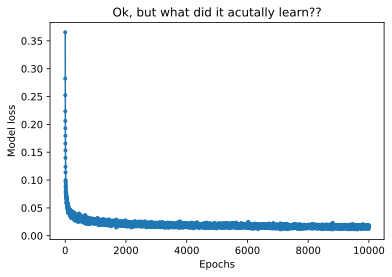

In [22]:
# train the model
losses, net = function2trainTheModel()
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses, '.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.title('Ok, but what did it acutally learn??')
plt.show()

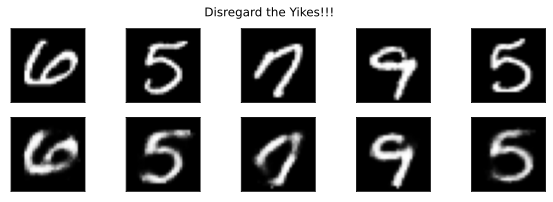

In [23]:
# repeat the visualization when testing the model
X = dataT[:5, :]
yHat = net(X)

# let's see what the model did!
fig, axs = plt.subplots(2, 5, figsize=(10,3))

for i in range(5):
    axs[0, i].imshow(X[i,:].view(28, 28).detach(), cmap='gray')
    axs[1, i].imshow(yHat[i, :].view(28, 28).detach(), cmap='gray')
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])

plt.suptitle('Disregard the Yikes!!!')
plt.show()

## Add noise to see a use case of an autoencoder

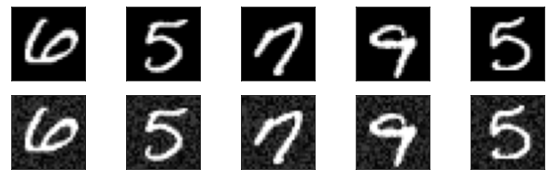

In [24]:
# grab a small set of images
X = dataT[:10, :]

# add noise
Xnoise = X + torch.rand_like(X) / 4

# clip at 1
Xnoise[Xnoise > 1] = 1

# show the noisy images
fig, axs = plt.subplots(2, 5, figsize=(10, 3))

for i in range(5):
    axs[0, i].imshow(X[i,:].view(28, 28).detach(), cmap='gray')
    axs[1, i].imshow(Xnoise[i, :].view(28, 28).detach(), cmap='gray')
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])

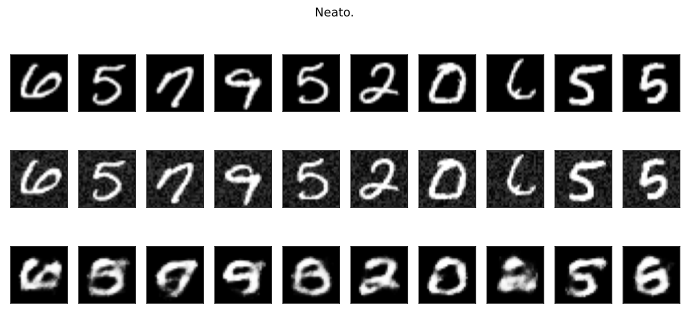

In [25]:
# run through the model
Y = net(Xnoise)

# show the noisy images
fig, axs = plt.subplots(3, 10, figsize=(12, 5))

for i in range(10):
    axs[0, i].imshow(X[i,:].view(28, 28).detach(), cmap='gray')
    axs[1, i].imshow(Xnoise[i, :].view(28, 28).detach(), cmap='gray')
    axs[2, i].imshow(Y[i, :].view(28, 28).detach(), cmap='gray')
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([]) 
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])
    axs[2, i].set_xticks([]), axs[2, i].set_yticks([])

plt.suptitle('Neato.')
plt.show()

In [ ]:
import numpy as np

In [ ]:
len(np.linspace(5, 100, 8))

8

In [ ]:
len(np.arange(5, 100, 8))

12

In [ ]:
len(np.arange(10, 500, 12))

41

In [ ]:
import os

In [ ]:
!touch readme.md

In [ ]:
os.path.isfile("readdme.md")

False

In [ ]:
os.remove('readme.md')

In [ ]:
os.path.isfile('readme.md')

False